# SPM testing 

# Include Libraries

In [1]:
from utils import load_cifar10_data
from utils import extract_DenseSift_descriptors
from utils import build_codebook
from utils import input_vector_encoder
from classifier import svm_classifier

import cv2
import time 
import numpy as np
from mnist import MNIST
from PIL import Image

import os 
from os.path import isfile, join

import sklearn
from sklearn.cluster import KMeans
from sklearn.datasets import fetch_mldata
from sklearn.metrics import confusion_matrix
from  matplotlib import pyplot as plt
import scipy.cluster.vq as vq
from scipy import misc

from plotConfusionMatrix import plot_confusion_matrix

/home/adityav/.virtualenvs/cv/local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/adityav/.virtualenvs/cv/local/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [8]:
def getMnistData(dataPath, trainSize=50000,validSize=10000,testSize=20000):
        
    # Load data and parse into usable numpy format
    mndata = MNIST(dataPath);
    
    train_Data = mndata.load_training()
    test_Data = mndata.load_testing()
    
    # Convert data to numpy format
    trainX = np.array(train_Data[0])
    trainY = np.array(train_Data[1])
    testX = np.array(test_Data[0])
    testY = np.array(test_Data[1])
    
    # Create data of given sizes
    validX = trainX[0:validSize];
    validY = trainY[0:validSize];
    trainX = trainX[validSize:validSize+trainSize]
    trainY = trainY[validSize:validSize+trainSize]
    testX = testX[0:testSize]
    testY = testY[0:testSize]
    
    # Normalize the data
#     normalize_mean = np.mean(trainX,0)
#     normalize_std  = np.std(trainX-normalize_mean,0)+0.0001
    
#     trainX = np.true_divide(trainX - normalize_mean , normalize_std)
#     validX = np.true_divide(validX - normalize_mean , normalize_std)
#     testX =  np.true_divide(testX  - normalize_mean , normalize_std)
    
    return [trainX,trainY,validX,validY,testX,testY]

# Get data in the format required for SPM code
def getMnistDataForSPM(dataPath):
    trainX,trainY,validX,validY,testX,testY = getMnistData(dataPath, 10000,0,20000)

    trainX_List = []
    trainY_List = []
    for i,image in enumerate(trainX):
        image = trainX[i]
        trainX_List.append(image.reshape([28,28]).astype('uint8'))
        trainY_List.append(str(trainY[i]))

    testX_List = []
    testY_List = []
    for i,image in enumerate(testX):
        image = testX[i]
        testX_List.append(image.reshape([28,28]).astype('uint8'))
        testY_List.append(str(testY[i]))

    print("No of training Examples: ", len(trainX_List))
    print("No of test Examples: ", len(testX_List))
    return trainX_List, trainY_List, testX_List, testY_List

In [9]:
def build_spatial_pyramid(image, descriptor, level):
    """
    Rebuild the descriptors according to the level of pyramid
    """
    assert 0 <= level <= 2, "Level Error"
    step_size = DSIFT_STEP_SIZE
    from utils import DSIFT_STEP_SIZE as s
    assert s == step_size, "step_size must equal to DSIFT_STEP_SIZE\
                            in utils.extract_DenseSift_descriptors()"
    h = image.shape[0] / step_size
    w = image.shape[1] / step_size
    idx_crop = np.array(range(len(descriptor))).reshape(h,w)
    size = idx_crop.itemsize
    height, width = idx_crop.shape
    bh, bw = 2**(3-level), 2**(3-level)
    shape = (height/bh, width/bw, bh, bw)
    strides = size * np.array([width*bh, bw, width, 1])
    crops = np.lib.stride_tricks.as_strided(
            idx_crop, shape=shape, strides=strides)
    des_idxs = [col_block.flatten().tolist() for row_block in crops
                for col_block in row_block]
    pyramid = []
    for idxs in des_idxs:
        pyramid.append(np.asarray([descriptor[idx] for idx in idxs]))
    return pyramid

def spatial_pyramid_matching(image, descriptor, codebook, level):
    pyramid = []
    if level == 0:
        pyramid += build_spatial_pyramid(image, descriptor, level=0)
        code = [input_vector_encoder(crop, codebook) for crop in pyramid]
        return np.asarray(code).flatten()
    if level == 1:
        pyramid += build_spatial_pyramid(image, descriptor, level=0)
        pyramid += build_spatial_pyramid(image, descriptor, level=1)
        code = [input_vector_encoder(crop, codebook) for crop in pyramid]
        code_level_0 = 0.5 * np.asarray(code[0]).flatten()
        code_level_1 = 0.5 * np.asarray(code[1:]).flatten()
        return np.concatenate((code_level_0, code_level_1))
    if level == 2:
        pyramid += build_spatial_pyramid(image, descriptor, level=0)
        pyramid += build_spatial_pyramid(image, descriptor, level=1)
        pyramid += build_spatial_pyramid(image, descriptor, level=2)
        code = [input_vector_encoder(crop, codebook) for crop in pyramid]
        code_level_0 = 0.25 * np.asarray(code[0]).flatten()
        code_level_1 = 0.25 * np.asarray(code[1:5]).flatten()
        code_level_2 = 0.5 * np.asarray(code[5:]).flatten()
        return np.concatenate((code_level_0, code_level_1, code_level_2))

In [121]:
VOC_SIZE = 100
PYRAMID_LEVEL = 1

DSIFT_STEP_SIZE = 4
# DSIFT_STEP_SIZE is related to the function
# extract_DenseSift_descriptors in utils.py
# and build_spatial_pyramid in spm.py


if __name__ == '__main__':
    dataPath = '/home/adityav/UCSD/Spring17/COGS260_ImageRecognition/python-mnist/data/'
    x_train, y_train, x_test, y_test = getMnistDataForSPM(dataPath)
        
    img = x_train[0]

    print "Dense SIFT feature extraction"
    x_train_feature = [extract_DenseSift_descriptors(img) for img in x_train]
    x_test_feature = [extract_DenseSift_descriptors(img) for img in x_test]
    x_train_kp, x_train_des = zip(*x_train_feature)
    x_test_kp, x_test_des = zip(*x_test_feature)

    print "Train/Test split: {:d}/{:d}".format(len(y_train), len(y_test))
    print "Codebook Size: {:d}".format(VOC_SIZE)
    print "Pyramid level: {:d}".format(PYRAMID_LEVEL)
    print "Building the codebook, it will take some time"
    codebook = build_codebook(x_train_des, VOC_SIZE)
    import cPickle
    with open('./spm_lv1_codebook.pkl','w') as f:
        cPickle.dump(codebook, f)

    print "Spatial Pyramid Matching encoding"
    x_train = [spatial_pyramid_matching(x_train[i],
                                        x_train_des[i],
                                        codebook,
                                        level=PYRAMID_LEVEL)
                                        for i in xrange(len(x_train))]

    x_test = [spatial_pyramid_matching(x_test[i],
                                       x_test_des[i],
                                       codebook,
                                       level=PYRAMID_LEVEL) for i in xrange(len(x_test))]

    x_train = np.asarray(x_train)
    x_test = np.asarray(x_test)



('No of training Examples: ', 10000)
('No of test Examples: ', 10000)
(28, 28)
<type 'numpy.ndarray'>
[[  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36]
 [  0   0   0   0   0   0   0  49 238 253]
 [  0   0   0   0   0   0   0  18 219 253]
 [  0   0   0   0   0   0   0   0  80 156]]
Dense SIFT feature extraction
Train/Test split: 10000/10000
Codebook Size: 100
Pyramid level: 1
Building the codebook, it will take some time
Spatial Pyramid Matching encoding
Tuning hyper-parameters



classifier.py:18: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if x_test == None and y_test == None:


Best parameters set found on development set:

SVC(C=100.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=10.0, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Grid scores on development set:

0.113 (+/-0.000) for {'C': 0.001, 'gamma': 0.001}
0.113 (+/-0.000) for {'C': 0.001, 'gamma': 0.01}
0.113 (+/-0.000) for {'C': 0.001, 'gamma': 0.1}
0.113 (+/-0.000) for {'C': 0.001, 'gamma': 1.0}
0.113 (+/-0.000) for {'C': 0.001, 'gamma': 10.0}
0.113 (+/-0.000) for {'C': 0.001, 'gamma': 100.0}
0.113 (+/-0.000) for {'C': 0.01, 'gamma': 0.001}
0.113 (+/-0.000) for {'C': 0.01, 'gamma': 0.01}
0.113 (+/-0.000) for {'C': 0.01, 'gamma': 0.1}
0.113 (+/-0.000) for {'C': 0.01, 'gamma': 1.0}
0.583 (+/-0.034) for {'C': 0.01, 'gamma': 10.0}
0.724 (+/-0.032) for {'C': 0.01, 'gamma': 100.0}
0.113 (+/-0.000) for {'C': 0.1, 'gamma': 0.001}
0.113 (+/-0.000) for {'C': 0.1, 'gamma': 0.01}
0.113 (+/-0.000) f

# Plot Results

In [14]:
# Build SVM classifier and print report
y_true, y_pred = svm_classifier(x_train, y_train, x_test, y_test)

# Plot confusion matrix
class_names=['Digit 0','Digit 1','Digit 2','Digit 3','Digit 4','Digit 5','Digit 6','Digit 7','Digit 8','Digit 9']
cnf_matrix = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix - SVM classification')

Tuning hyper-parameters

Best parameters set found on development set:

SVC(C=100.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=10.0, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Grid scores on development set:

0.113 (+/-0.000) for {'C': 0.001, 'gamma': 0.001}
0.113 (+/-0.000) for {'C': 0.001, 'gamma': 0.01}
0.113 (+/-0.000) for {'C': 0.001, 'gamma': 0.1}
0.113 (+/-0.000) for {'C': 0.001, 'gamma': 1.0}
0.113 (+/-0.000) for {'C': 0.001, 'gamma': 10.0}
0.113 (+/-0.000) for {'C': 0.001, 'gamma': 100.0}
0.113 (+/-0.000) for {'C': 0.01, 'gamma': 0.001}
0.113 (+/-0.000) for {'C': 0.01, 'gamma': 0.01}
0.113 (+/-0.000) for {'C': 0.01, 'gamma': 0.1}
0.113 (+/-0.000) for {'C': 0.01, 'gamma': 1.0}
0.583 (+/-0.034) for {'C': 0.01, 'gamma': 10.0}
0.724 (+/-0.032) for {'C': 0.01, 'gamma': 100.0}
0.113 (+/-0.000) for {'C': 0.1, 'gamma': 0.001}
0.113 (+/-0.000) for {'C': 0.1, 'gamma':

Normalized confusion matrix


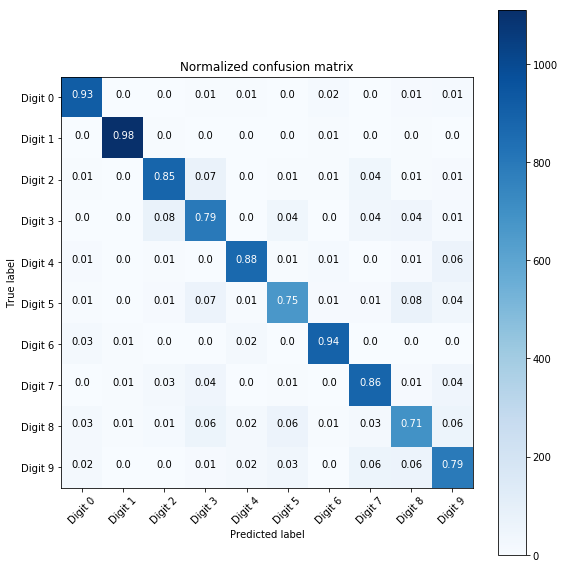